In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/My Drive/

/gdrive/My Drive


In [40]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [34]:
from keras.preprocessing.image import ImageDataGenerator

valid_data_gen = ImageDataGenerator(rescale=1/255., validation_split=0.2)

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=90,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        shear_range=0.2,
                                        validation_split=0.2,
                                        rescale=1/255.) # rescale value is multiplied to the image

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory='/gdrive/My Drive/AN2DL/training_data_final',
                                                       target_size=(256,256),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=64,
                                                       subset='training',
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory('/gdrive/My Drive/AN2DL/training_data_final',
                                              target_size=(256,256),
                                              batch_size=64,
                                              color_mode='rgb',
                                              class_mode='categorical',
                                              classes=None,
                                              subset='validation',
                                              shuffle=True,
                                              seed=seed)

Found 2836 images belonging to 8 classes.
Found 706 images belonging to 8 classes.


In [6]:
print("Assigned labels")
print(aug_train_gen.class_indices)
print()
print("Target classes")
print(aug_train_gen.classes)

Assigned labels
{'Species1': 0, 'Species2': 1, 'Species3': 2, 'Species4': 3, 'Species5': 4, 'Species6': 5, 'Species7': 6, 'Species8': 7}

Target classes
[0 0 0 ... 7 7 7]


In [7]:
# Settled on these values after multiple attempts on using various values
input_shape = (256, 256, 3)
epochs = 200

# CNN built from scratch

In [8]:
#########################################
# CNN built from scratch
#########################################

def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    conv1 = tfkl.Conv2D(
        filters=32,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D()(conv1)

    conv2 = tfkl.Conv2D(
        filters=64,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D()(conv2)

    conv3 = tfkl.Conv2D(
        filters=128,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D()(conv3)

    conv4 = tfkl.Conv2D(
        filters=256,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D()(conv4)

    conv5 = tfkl.Conv2D(
        filters=512,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D()(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    dropout = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.HeUniform(seed), activation='relu')(dropout)
    dropout = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [9]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [ ]:
# Build model (for  augmentation training)
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856 

In [ ]:
# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='CNN_Aug')

# Train CNN model built from scratch
history = model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = aug_callbacks,
).history

Epoch 1/100
23/23 [==============================] - 415s 18s/step - loss: 5.3876 - accuracy: 0.1707 - val_loss: 1.8955 - val_accuracy: 0.2408
Epoch 2/100
23/23 [==============================] - 48s 2s/step - loss: 1.8446 - accuracy: 0.2870 - val_loss: 1.8789 - val_accuracy: 0.2592
Epoch 3/100
23/23 [==============================] - 49s 2s/step - loss: 1.7928 - accuracy: 0.2906 - val_loss: 1.8720 - val_accuracy: 0.2436
Epoch 4/100
23/23 [==============================] - 48s 2s/step - loss: 1.7373 - accuracy: 0.3068 - val_loss: 1.6750 - val_accuracy: 0.3116
Epoch 5/100
23/23 [==============================] - 48s 2s/step - loss: 1.5921 - accuracy: 0.3946 - val_loss: 1.5763 - val_accuracy: 0.3796
Epoch 6/100
23/23 [==============================] - 47s 2s/step - loss: 1.5804 - accuracy: 0.4207 - val_loss: 1.6254 - val_accuracy: 0.3598
Epoch 7/100
23/23 [==============================] - 48s 2s/step - loss: 1.5076 - accuracy: 0.4369 - val_loss: 1.7682 - val_accuracy: 0.3782
Epoch 8/100

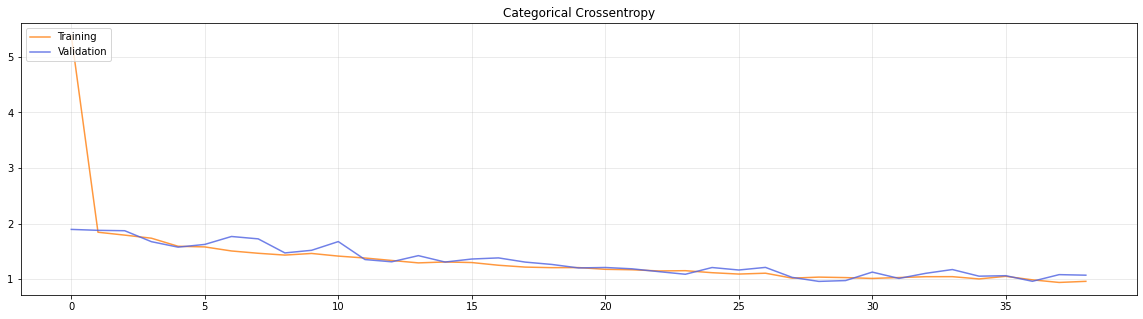

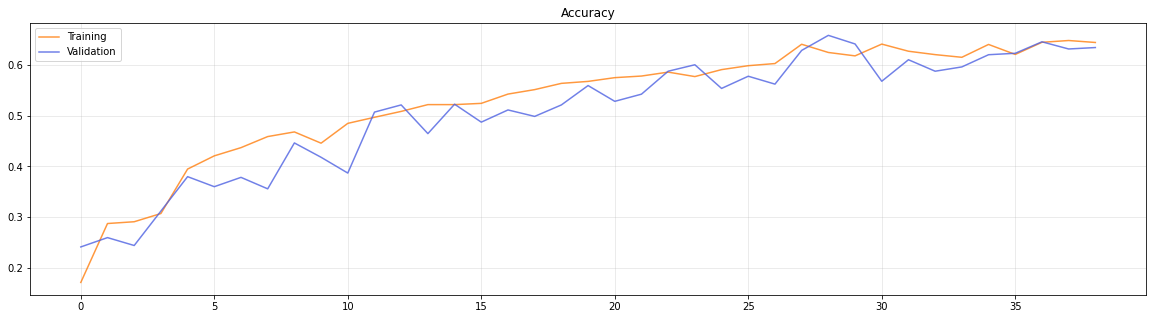

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save best epoch model
model.save("data_augmentation_experiments/CNN_Aug_Best128")

# Transfer Learning - ResNet50V2

In [ ]:
resnet = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)

model_resnet = tf.keras.Sequential()
model_resnet.add(resnet)
model_resnet.add(tf.keras.layers.Flatten())
model_resnet.add(tf.keras.layers.Dense(units=64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model_resnet.add(tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model_resnet.add(tf.keras.layers.Dense(units=8, activation='softmax'))

model_resnet.summary()

94668760/94668760 [==============================] - 5s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_3 (Dense)             (None, 64)                8388672   
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 8)                 264       
                                                                 
Total params: 31,955,816
Trainable params: 31,910,376
Non-trainable params: 45,440
______________________________________

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
lr = 1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
metrics = ['accuracy']
model_resnet.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Create folders and callbacks and fit
resnet50_callbacks = create_folders_and_callbacks(model_name='CNN_TF_RESNET50')

# Train the model
history = model_resnet.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = resnet50_callbacks,
).history

Epoch 1/100
23/23 [==============================] - 81s 3s/step - loss: 1.9217 - accuracy: 0.2817 - val_loss: 2.3552 - val_accuracy: 0.1926
Epoch 2/100
23/23 [==============================] - 66s 3s/step - loss: 1.5659 - accuracy: 0.4376 - val_loss: 2.4690 - val_accuracy: 0.2450
Epoch 3/100
23/23 [==============================] - 66s 3s/step - loss: 1.3425 - accuracy: 0.5261 - val_loss: 2.7071 - val_accuracy: 0.2790
Epoch 4/100
23/23 [==============================] - 66s 3s/step - loss: 1.1976 - accuracy: 0.5832 - val_loss: 2.6322 - val_accuracy: 0.3329
Epoch 5/100
23/23 [==============================] - 65s 3s/step - loss: 1.0665 - accuracy: 0.6382 - val_loss: 2.3952 - val_accuracy: 0.3810
Epoch 6/100
23/23 [==============================] - 65s 3s/step - loss: 0.9988 - accuracy: 0.6580 - val_loss: 2.1095 - val_accuracy: 0.4334
Epoch 7/100
23/23 [==============================] - 65s 3s/step - loss: 0.8868 - accuracy: 0.7031 - val_loss: 1.7643 - val_accuracy: 0.5142
Epoch 8/100
2

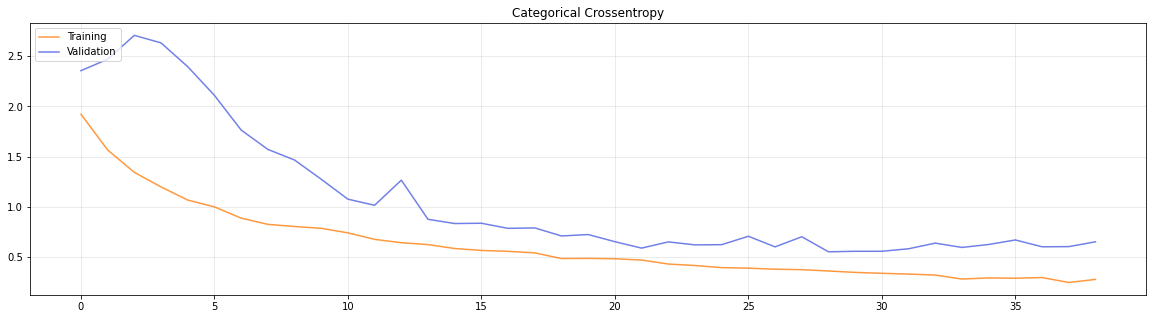

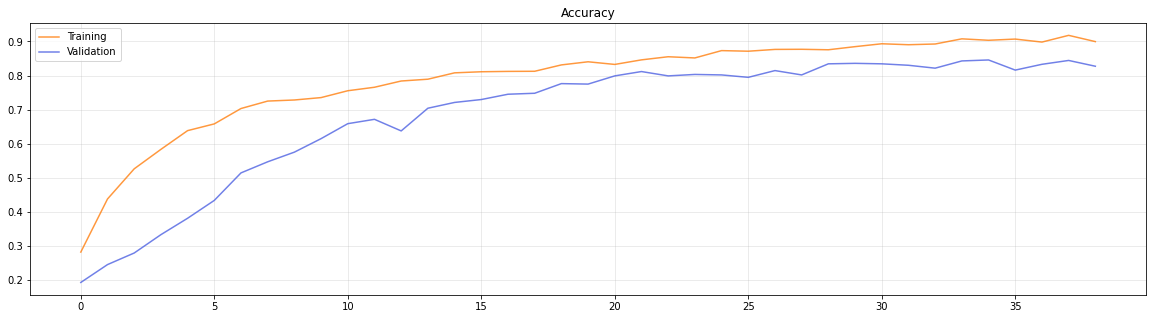

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# Transfer Learning - VGG19



In [ ]:
model_vgg19 = tf.keras.Sequential()
vgg19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=input_shape) 
model_vgg19.add(vgg19)
model_vgg19.add(tf.keras.layers.Flatten())
model_vgg19.add(tf.keras.layers.Dense(units=128, activation='relu'))
model_vgg19.add(tf.keras.layers.Dropout(0.3))
model_vgg19.add(tf.keras.layers.Dense(units=8, activation='softmax'))

model_vgg19.compile(optimizer=optimizer, loss=loss, metrics=metrics)


model_vgg19.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               4194432   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 24,219,848
Trainable params: 4,195,464
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
# Create folders and callbacks and fit
vgg19_callbacks = create_folders_and_callbacks(model_name='CNN_TF_VGG19')

# Train the model
history = model_vgg19.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = vgg19_callbacks,
).history

## Fine Tuning 

In [ ]:
## Fine Tuning
ft_vgg19_model = tfk.models.load_model("data_augmentation_experiments/CNN_TL_VGG19_BS64")
ft_vgg19_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 64)                2097216   
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 8)                 264       
                                                                 
Total params: 22,123,944
Trainable params: 22,123,944
Non-trainable params: 0
_________________________________________________________________


In [ ]:
ft_vgg19_model.get_layer('vgg19').trainable = True
for i, layer in enumerate(ft_vgg19_model.get_layer('vgg19').layers):
   print(i, layer.name, ft_vgg19_model.trainable)

0 input_2 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_conv4 True
11 block3_pool True
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True


In [ ]:
# Freeze first N layers
for i, layer in enumerate(ft_vgg19_model.get_layer('vgg19').layers[:17]):
  layer.trainable=False
for i, layer in enumerate(ft_vgg19_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)
ft_vgg19_model.summary()

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 False
16 block4_pool False
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 64)                2097216   
                                                         

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
lr = 5e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
metrics = ['accuracy']
ft_vgg19_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
# Create folders and callbacks and fit
vgg19_ft_callbacks = create_folders_and_callbacks(model_name='CNN_TL_VGG19_BS64_FT')

# Train the model
ft_vgg19_history = ft_vgg19_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = vgg19_ft_callbacks,
).history

Epoch 1/200
45/45 [==============================] - 1950s 43s/step - loss: 0.5869 - accuracy: 0.9556 - val_loss: 0.8801 - val_accuracy: 0.8853
Epoch 2/200
45/45 [==============================] - 58s 1s/step - loss: 0.5713 - accuracy: 0.9566 - val_loss: 0.8909 - val_accuracy: 0.8768
Epoch 3/200
45/45 [==============================] - 58s 1s/step - loss: 0.5374 - accuracy: 0.9676 - val_loss: 0.8676 - val_accuracy: 0.8909
Epoch 4/200
45/45 [==============================] - 57s 1s/step - loss: 0.5390 - accuracy: 0.9609 - val_loss: 0.8630 - val_accuracy: 0.8824
Epoch 5/200
45/45 [==============================] - 58s 1s/step - loss: 0.5419 - accuracy: 0.9587 - val_loss: 0.8370 - val_accuracy: 0.8796
Epoch 6/200
45/45 [==============================] - 58s 1s/step - loss: 0.5122 - accuracy: 0.9651 - val_loss: 0.8573 - val_accuracy: 0.8952
Epoch 7/200
45/45 [==============================] - 59s 1s/step - loss: 0.5064 - accuracy: 0.9679 - val_loss: 0.8177 - val_accuracy: 0.8938
Epoch 8/20

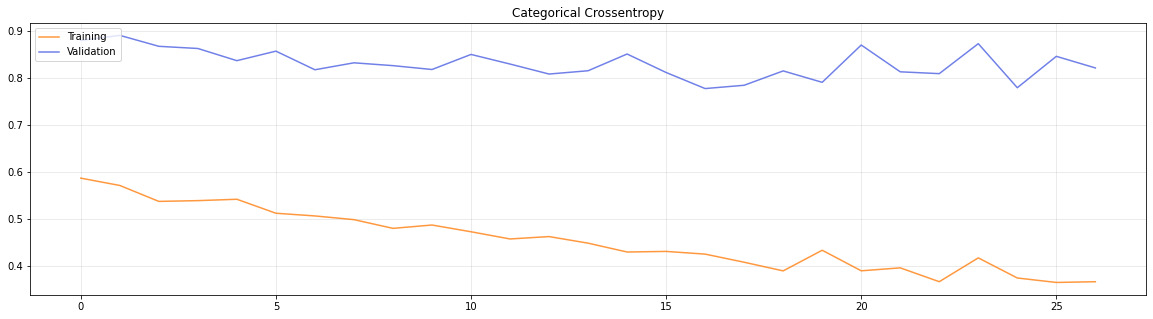

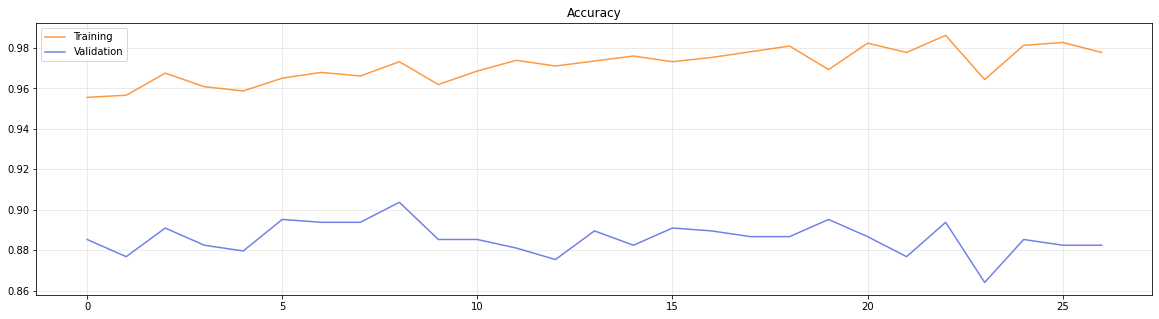

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(ft_vgg19_history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(ft_vgg19_history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(ft_vgg19_history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(ft_vgg19_history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save best epoch model
ft_vgg19_model.save("data_augmentation_experiments/CNN_TL_VGG19_BS64_FT")

# Transfer Learning - InceptionV3
Adam Optimizer

In [ ]:
iv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
model_iv3 = tf.keras.Sequential()
model_iv3.add(iv3)
model_iv3.add(tf.keras.layers.Flatten())
model_iv3.add(tf.keras.layers.Dense(units=64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model_iv3.add(tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model_iv3.add(tf.keras.layers.Dense(units=8, activation='softmax'))

model_iv3.summary()

87910968/87910968 [==============================] - 7s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 64)                4718656   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
Total params: 26,523,784
Trainable params: 26,489,352
Non-trainable params: 34,432
________________________________________

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
lr = 1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
metrics = ['accuracy']
model_iv3.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Create folders and callbacks and fit
iv3_callbacks = create_folders_and_callbacks(model_name='CNN_TF_IV3')

# Train the model
history = model_iv3.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = iv3_callbacks,
).history

Epoch 1/100
45/45 [==============================] - 1813s 40s/step - loss: 2.0396 - accuracy: 0.1989 - val_loss: 1.9542 - val_accuracy: 0.2479
Epoch 2/100
45/45 [==============================] - 61s 1s/step - loss: 1.8843 - accuracy: 0.2831 - val_loss: 1.8264 - val_accuracy: 0.2918
Epoch 3/100
45/45 [==============================] - 61s 1s/step - loss: 1.7233 - accuracy: 0.3621 - val_loss: 1.7002 - val_accuracy: 0.3626
Epoch 4/100
45/45 [==============================] - 62s 1s/step - loss: 1.5857 - accuracy: 0.4425 - val_loss: 1.5593 - val_accuracy: 0.4306
Epoch 5/100
45/45 [==============================] - 63s 1s/step - loss: 1.4678 - accuracy: 0.4884 - val_loss: 1.4483 - val_accuracy: 0.4646
Epoch 6/100
45/45 [==============================] - 61s 1s/step - loss: 1.3494 - accuracy: 0.5381 - val_loss: 1.3595 - val_accuracy: 0.5057
Epoch 7/100
45/45 [==============================] - 62s 1s/step - loss: 1.2957 - accuracy: 0.5578 - val_loss: 1.2935 - val_accuracy: 0.5382
Epoch 8/10

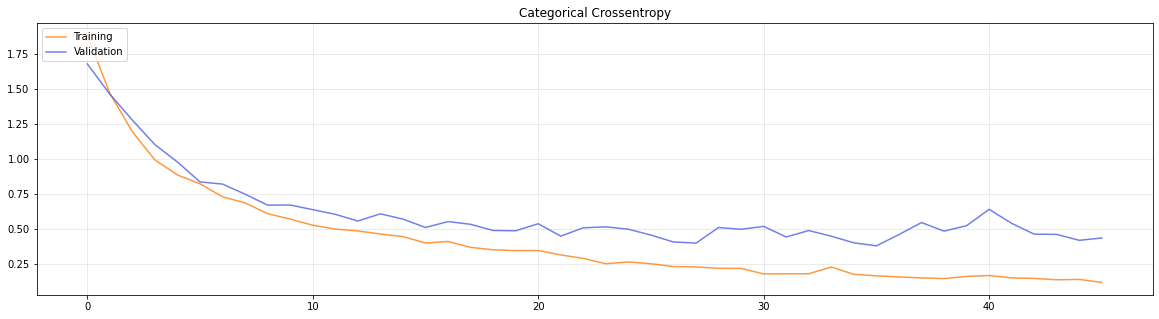

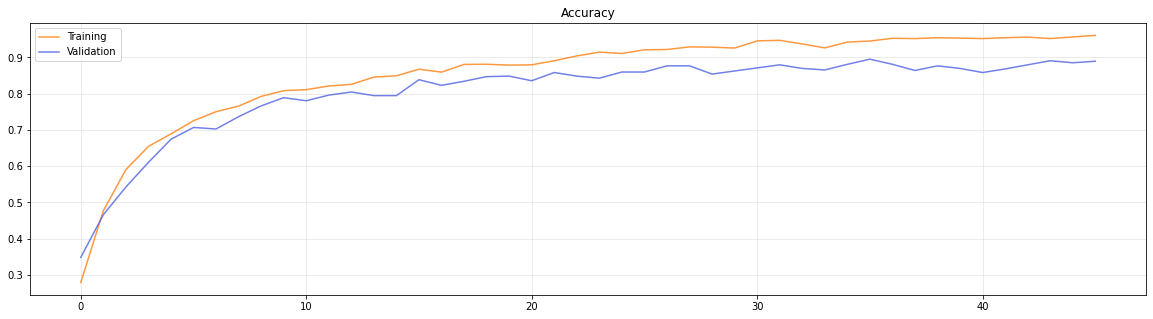

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save best epoch model
model_iv3.save("data_augmentation_experiments/CNN_TL_IV3_BS64")

# Transfer Learning - EfficientNetB2

In [ ]:
effb2 = tf.keras.applications.EfficientNetB2(weights='imagenet', include_top=False, input_shape=input_shape)

model_effb2 = tf.keras.Sequential()
model_effb2.add(effb2)
model_effb2.add(tf.keras.layers.Flatten())
model_effb2.add(tf.keras.layers.Dense(units=64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model_effb2.add(tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model_effb2.add(tf.keras.layers.Dense(units=8, activation='softmax'))

model_effb2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 8, 8, 1408)       7768569   
                                                                 
 flatten (Flatten)           (None, 90112)             0         
                                                                 
 dense (Dense)               (None, 64)                5767232   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
Total params: 13,538,145
Trainable params: 13,470,570
Non-trainable params: 67,575
_________________________________________________________________


In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
metrics = ['accuracy']
model_effb2.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Create folders and callbacks and fit
effb2_callbacks = create_folders_and_callbacks(model_name='CNN_TF_EFFB2')

# Train the model
history = model_effb2.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = effb2_callbacks,
).history

Epoch 1/200
45/45 [==============================] - 1755s 38s/step - loss: 1.7383 - accuracy: 0.3593 - val_loss: 3.5949 - val_accuracy: 0.1459
Epoch 2/200
45/45 [==============================] - 1690s 38s/step - loss: 1.2997 - accuracy: 0.5444 - val_loss: 4.9069 - val_accuracy: 0.1459
Epoch 3/200
 3/45 [=>............................] - ETA: 24:51 - loss: 1.1004 - accuracy: 0.6094

# Transfer Learning - InceptionV3
SGD Optimizer

In [ ]:
## InceptionV3
iv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
inputs = tfk.Input(shape=input_shape)
x = iv3(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)  
output_layer = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='tl_model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.SGD(), metrics=['accuracy'])


tl_model.summary()


Model: "tl_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 Flattening (Flatten)        (None, 73728)             0         
                                                                 
 dropout_1 (Dropout)         (None, 73728)             0         
                                                                 
 dense_1 (Dense)             (None, 8)                 589832    
                                                                 
Total params: 22,392,616
Trainable params: 22,358,184
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
# Create folders and callbacks and fit
iv3_tl_callbacks = create_folders_and_callbacks(model_name='CNN_TL_EX_IV3_BS64_SGD')

# Train the model
iv3_tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = iv3_tl_callbacks,
).history

Epoch 1/200
45/45 [==============================] - 64s 1s/step - loss: 2.5292 - accuracy: 0.2013 - val_loss: 1.9758 - val_accuracy: 0.2507
Epoch 2/200
45/45 [==============================] - 58s 1s/step - loss: 1.8134 - accuracy: 0.3575 - val_loss: 1.8527 - val_accuracy: 0.2960
Epoch 3/200
45/45 [==============================] - 57s 1s/step - loss: 1.4499 - accuracy: 0.5035 - val_loss: 1.3509 - val_accuracy: 0.5127
Epoch 4/200
45/45 [==============================] - 57s 1s/step - loss: 1.1949 - accuracy: 0.5945 - val_loss: 1.3322 - val_accuracy: 0.5722
Epoch 5/200
45/45 [==============================] - 59s 1s/step - loss: 1.0664 - accuracy: 0.6361 - val_loss: 0.9730 - val_accuracy: 0.6586
Epoch 6/200
45/45 [==============================] - 60s 1s/step - loss: 0.8907 - accuracy: 0.7035 - val_loss: 0.8946 - val_accuracy: 0.6898
Epoch 7/200
45/45 [==============================] - 59s 1s/step - loss: 0.7978 - accuracy: 0.7253 - val_loss: 0.6761 - val_accuracy: 0.7790
Epoch 8/200
4

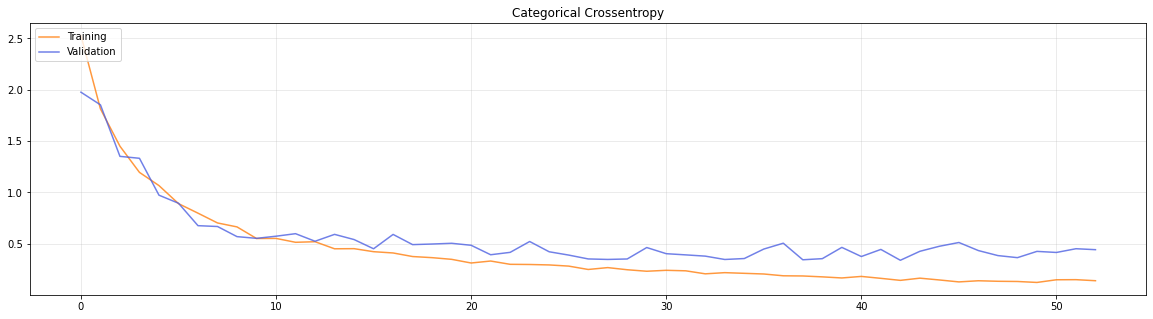

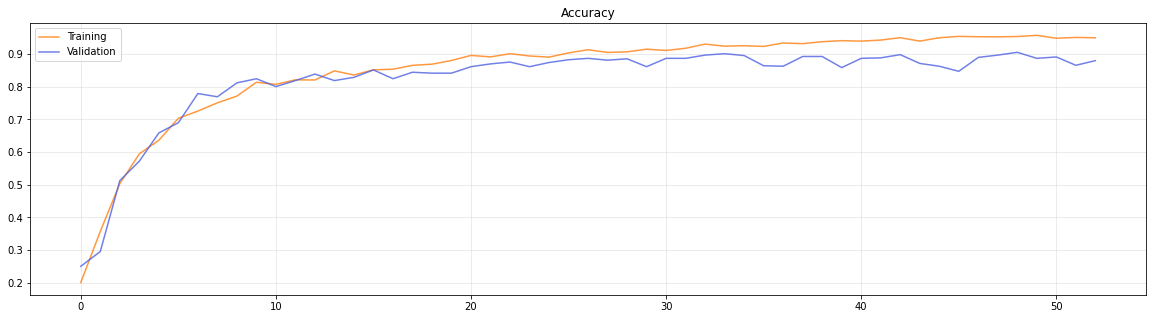

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(iv3_tl_history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(iv3_tl_history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(iv3_tl_history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(iv3_tl_history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# Transfer Learning - InceptionResNetV2

In [ ]:
## InceptionResNet
irv2 = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
inputs = tfk.Input(shape=input_shape)
x = irv2(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.4, seed=seed)(x)  
output_layer = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed),
    kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)


irv2_model = tfk.Model(inputs=inputs, outputs=output_layer, name='irv2_model')

# Compile the model
irv2_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.SGD(momentum=0.7), metrics=['accuracy'])


irv2_model.summary()


219055592/219055592 [==============================] - 1s 0us/step
Model: "irv2_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 Flattening (Flatten)        (None, 55296)             0         
                                                                 
 dropout (Dropout)           (None, 55296)             0         
                                                                 
 dense (Dense)               (None, 8)                 442376    
                                                                 
Total params: 54,779,112
Trainable params: 54,718,568
N

In [ ]:
# Create folders and callbacks and fit
irv2_tl_callbacks = create_folders_and_callbacks(model_name='CNN_TL_IRV2_BS16_SGD')

# Train the model
irv2_tl_history = irv2_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = irv2_tl_callbacks,
).history

Epoch 1/200
45/45 [==============================] - 529s 11s/step - loss: 2.8228 - accuracy: 0.3265 - val_loss: 4.2277 - val_accuracy: 0.1487
Epoch 2/200
45/45 [==============================] - 81s 2s/step - loss: 1.2935 - accuracy: 0.5843 - val_loss: 1.8271 - val_accuracy: 0.3173
Epoch 3/200
45/45 [==============================] - 81s 2s/step - loss: 0.9946 - accuracy: 0.6597 - val_loss: 1.4666 - val_accuracy: 0.5028
Epoch 4/200
45/45 [==============================] - 83s 2s/step - loss: 0.8499 - accuracy: 0.7186 - val_loss: 1.2760 - val_accuracy: 0.6020
Epoch 5/200
45/45 [==============================] - 80s 2s/step - loss: 0.7481 - accuracy: 0.7429 - val_loss: 1.2887 - val_accuracy: 0.6261
Epoch 6/200
45/45 [==============================] - 82s 2s/step - loss: 0.6735 - accuracy: 0.7701 - val_loss: 1.6680 - val_accuracy: 0.6601
Epoch 7/200
45/45 [==============================] - 81s 2s/step - loss: 0.6402 - accuracy: 0.7916 - val_loss: 1.0593 - val_accuracy: 0.7479
Epoch 8/200

In [ ]:
# Save best epoch model
irv2_model.save("data_augmentation_experiments/CNN_TL_IRV2_BS16_SGD")

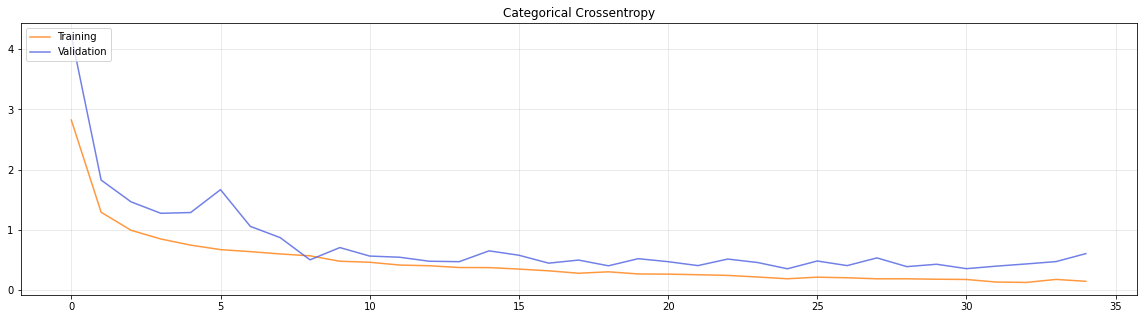

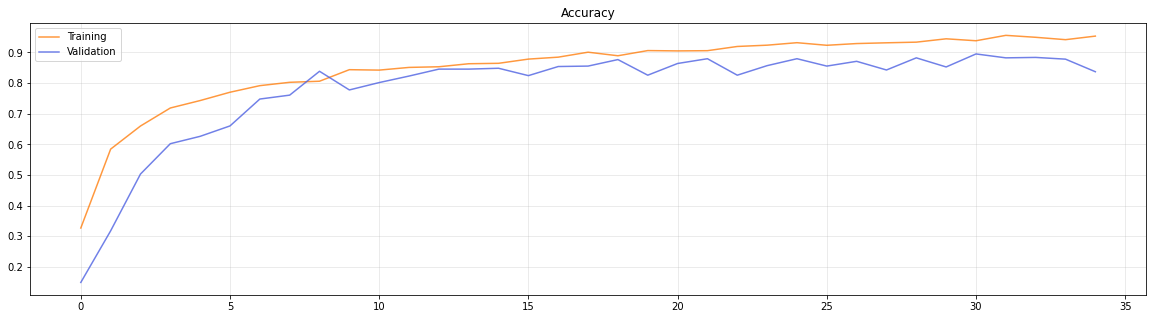

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(irv2_tl_history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(irv2_tl_history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(irv2_tl_history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(irv2_tl_history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# Generating class weights
To handle imbalanced classes

dict_items([(0, 149), (1, 426), (2, 412), (3, 409), (4, 425), (5, 178), (6, 430), (7, 407)])


Text(0, 0.5, 'Number of Images')

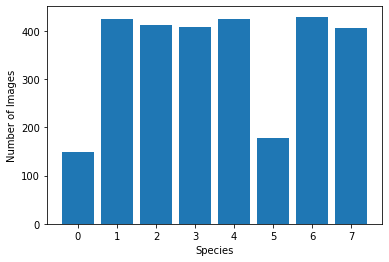

In [16]:
from collections import Counter

counter = Counter(aug_train_gen.classes)

print(counter.items())

plt.bar(list(counter.keys()),list(counter.values()))
plt.xlabel("Species")
plt.ylabel("Number of Images")

In [11]:
from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight(
           class_weight='balanced',
            classes=np.unique(aug_train_gen.classes), 
            y=aug_train_gen.classes)
class_weights_dict = dict(zip(np.unique(aug_train_gen.classes), class_weights))
class_weights_dict

{0: 2.379194630872483,
 1: 0.8321596244131455,
 2: 0.8604368932038835,
 3: 0.8667481662591687,
 4: 0.8341176470588235,
 5: 1.9915730337078652,
 6: 0.8244186046511628,
 7: 0.871007371007371}

# Transfer Learning - InceptionV3
Traind using class weights, SGD Optimizer and L2 regularization penalty

In [ ]:
## InceptionV3
iv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
inputs = tfk.Input(shape=input_shape)
x = iv3(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.4, seed=seed)(x)  
output_layer = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed),
    kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)


tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='tl_model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.SGD(), metrics=['accuracy'])


tl_model.summary()

Model: "tl_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 Flattening (Flatten)        (None, 73728)             0         
                                                                 
 dropout_3 (Dropout)         (None, 73728)             0         
                                                                 
 dense_3 (Dense)             (None, 8)                 589832    
                                                                 
Total params: 22,392,616
Trainable params: 22,358,184
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
# Create folders and callbacks and fit
iv3_tl_callbacks = create_folders_and_callbacks(model_name='CNN_IV3_BS64_SGD_CW')

# Train the model
iv3_tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = iv3_tl_callbacks,
    class_weight = class_weights_dict,
).history

Epoch 1/200
45/45 [==============================] - 64s 1s/step - loss: 2.8342 - accuracy: 0.1714 - val_loss: 2.0723 - val_accuracy: 0.1870
Epoch 2/200
45/45 [==============================] - 57s 1s/step - loss: 2.1081 - accuracy: 0.2814 - val_loss: 2.3734 - val_accuracy: 0.1501
Epoch 3/200
45/45 [==============================] - 57s 1s/step - loss: 1.8764 - accuracy: 0.3149 - val_loss: 1.7829 - val_accuracy: 0.3144
Epoch 4/200
45/45 [==============================] - 57s 1s/step - loss: 1.6188 - accuracy: 0.3935 - val_loss: 1.3784 - val_accuracy: 0.4575
Epoch 5/200
45/45 [==============================] - 57s 1s/step - loss: 1.5651 - accuracy: 0.4866 - val_loss: 1.2777 - val_accuracy: 0.5312
Epoch 6/200
45/45 [==============================] - 57s 1s/step - loss: 1.2693 - accuracy: 0.5578 - val_loss: 1.1680 - val_accuracy: 0.4958
Epoch 7/200
45/45 [==============================] - 57s 1s/step - loss: 1.1111 - accuracy: 0.6238 - val_loss: 0.9787 - val_accuracy: 0.6176
Epoch 8/200
4

In [ ]:
# Save best epoch model
tl_model.save("data_augmentation_experiments/CNN_IV3_BS64_SGD_CW")

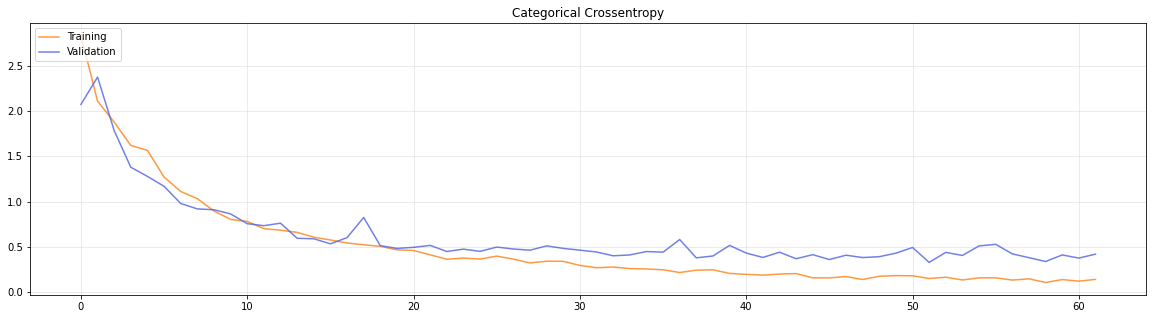

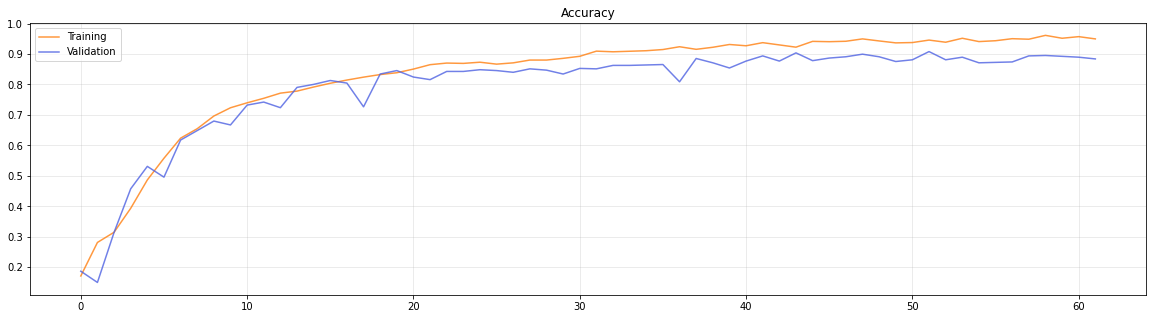

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(iv3_tl_history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(iv3_tl_history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(iv3_tl_history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(iv3_tl_history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## Fine Tuning InceptionV3 trained with class weights

In [ ]:
## Fine Tuning IV3 model with class weights
ft_iv3_cw_model = tfk.models.load_model("data_augmentation_experiments/CNN_IV3_BS64_SGD_CW")
ft_iv3_cw_model.summary()

Model: "tl_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 Flattening (Flatten)        (None, 73728)             0         
                                                                 
 dropout_3 (Dropout)         (None, 73728)             0         
                                                                 
 dense_3 (Dense)             (None, 8)                 589832    
                                                                 
Total params: 22,392,616
Trainable params: 22,358,184
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
ft_iv3_cw_model.get_layer('inception_v3').trainable = True
for i, layer in enumerate(ft_iv3_cw_model.get_layer('inception_v3').layers):
   print(i, layer.name, ft_iv3_cw_model.trainable)

0 input_7 True
1 conv2d_391 True
2 batch_normalization_391 True
3 activation_391 True
4 conv2d_392 True
5 batch_normalization_392 True
6 activation_392 True
7 conv2d_393 True
8 batch_normalization_393 True
9 activation_393 True
10 max_pooling2d_12 True
11 conv2d_394 True
12 batch_normalization_394 True
13 activation_394 True
14 conv2d_395 True
15 batch_normalization_395 True
16 activation_395 True
17 max_pooling2d_13 True
18 conv2d_399 True
19 batch_normalization_399 True
20 activation_399 True
21 conv2d_397 True
22 conv2d_400 True
23 batch_normalization_397 True
24 batch_normalization_400 True
25 activation_397 True
26 activation_400 True
27 average_pooling2d_19 True
28 conv2d_396 True
29 conv2d_398 True
30 conv2d_401 True
31 conv2d_402 True
32 batch_normalization_396 True
33 batch_normalization_398 True
34 batch_normalization_401 True
35 batch_normalization_402 True
36 activation_396 True
37 activation_398 True
38 activation_401 True
39 activation_402 True
40 mixed0 True
41 conv2d_40

In [ ]:
# Freeze first 229 layers 
for i, layer in enumerate(ft_iv3_cw_model.get_layer('inception_v3').layers[:229]):
  layer.trainable=False
for i, layer in enumerate(ft_iv3_cw_model.get_layer('inception_v3').layers):
   print(i, layer.name, layer.trainable)
ft_iv3_cw_model.summary()

0 input_7 False
1 conv2d_391 False
2 batch_normalization_391 False
3 activation_391 False
4 conv2d_392 False
5 batch_normalization_392 False
6 activation_392 False
7 conv2d_393 False
8 batch_normalization_393 False
9 activation_393 False
10 max_pooling2d_12 False
11 conv2d_394 False
12 batch_normalization_394 False
13 activation_394 False
14 conv2d_395 False
15 batch_normalization_395 False
16 activation_395 False
17 max_pooling2d_13 False
18 conv2d_399 False
19 batch_normalization_399 False
20 activation_399 False
21 conv2d_397 False
22 conv2d_400 False
23 batch_normalization_397 False
24 batch_normalization_400 False
25 activation_397 False
26 activation_400 False
27 average_pooling2d_19 False
28 conv2d_396 False
29 conv2d_398 False
30 conv2d_401 False
31 conv2d_402 False
32 batch_normalization_396 False
33 batch_normalization_398 False
34 batch_normalization_401 False
35 batch_normalization_402 False
36 activation_396 False
37 activation_398 False
38 activation_401 False
39 activati

In [ ]:
# Various learning rates were experimented but smaller rates were preferred for fine tuning
loss = tf.keras.losses.CategoricalCrossentropy()
lr = 5e-4
m = 0.9
optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=m)
metrics = ['accuracy']
ft_iv3_cw_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
# Create folders and callbacks and fit
iv3_cw_ft_callbacks = create_folders_and_callbacks(model_name='CNN_TL_IV3_BS64_CW_FT')

# Train the model
ft_iv3_cw_history = ft_iv3_cw_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = iv3_cw_ft_callbacks,
    class_weight = class_weights_dict,
).history

Epoch 1/200
45/45 [==============================] - 1190s 26s/step - loss: 0.1203 - accuracy: 0.9573 - val_loss: 0.3192 - val_accuracy: 0.9122
Epoch 2/200
45/45 [==============================] - 53s 1s/step - loss: 0.1217 - accuracy: 0.9573 - val_loss: 0.3247 - val_accuracy: 0.9065
Epoch 3/200
45/45 [==============================] - 53s 1s/step - loss: 0.1170 - accuracy: 0.9591 - val_loss: 0.3145 - val_accuracy: 0.9122
Epoch 4/200
45/45 [==============================] - 53s 1s/step - loss: 0.1222 - accuracy: 0.9580 - val_loss: 0.3079 - val_accuracy: 0.9108
Epoch 5/200
45/45 [==============================] - 54s 1s/step - loss: 0.0920 - accuracy: 0.9693 - val_loss: 0.3180 - val_accuracy: 0.9093
Epoch 6/200
45/45 [==============================] - 54s 1s/step - loss: 0.0925 - accuracy: 0.9661 - val_loss: 0.3212 - val_accuracy: 0.9079
Epoch 7/200
45/45 [==============================] - 53s 1s/step - loss: 0.0935 - accuracy: 0.9658 - val_loss: 0.3077 - val_accuracy: 0.9193
Epoch 8/20

In [ ]:
# Save best epoch model
ft_iv3_cw_model.save("data_augmentation_experiments/CNN_IV3_BS64_SGD_CW_FT")

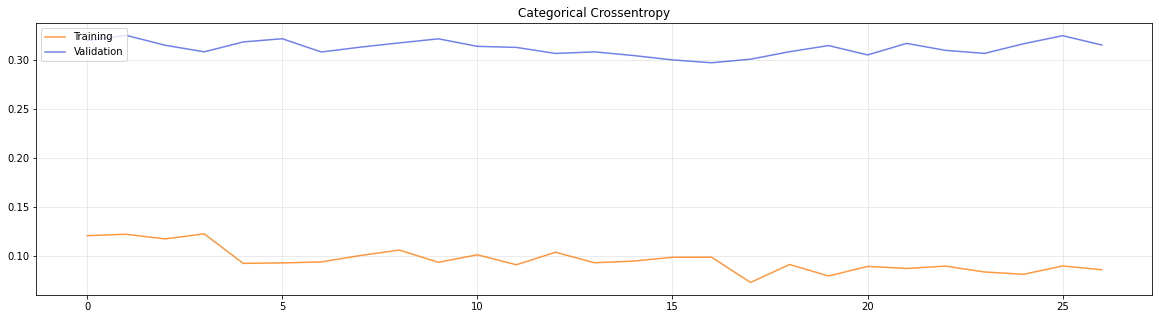

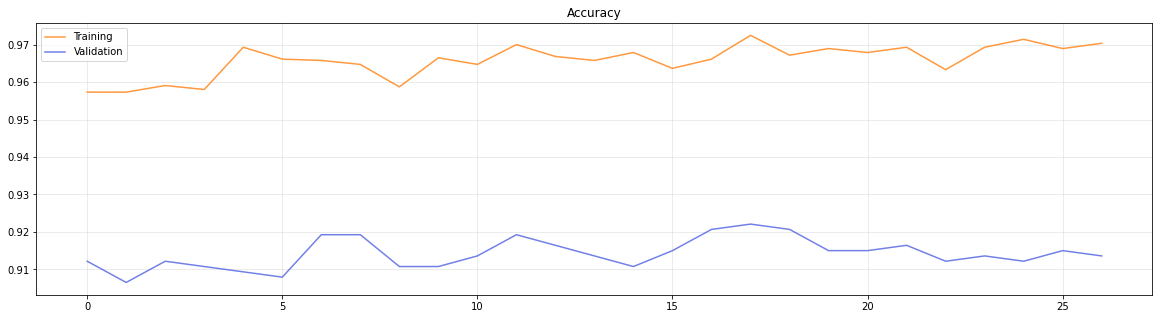

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(ft_iv3_cw_history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(ft_iv3_cw_history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(ft_iv3_cw_history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(ft_iv3_cw_history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# Generators with input size 96x96

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

valid_data_gen = ImageDataGenerator(rescale=1/255., validation_split=0.2)

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=90,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        shear_range=0.2,
                                        validation_split=0.2,
                                        rescale=1/255.) # rescale value is multiplied to the image

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory='/gdrive/My Drive/AN2DL/training_data_final',
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=64,
                                                       subset='training',
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory('/gdrive/My Drive/AN2DL/training_data_final',
                                              target_size=(96,96),
                                              batch_size=64,
                                              color_mode='rgb',
                                              class_mode='categorical',
                                              classes=None,
                                              subset='validation',
                                              shuffle=True,
                                              seed=seed)

Found 2836 images belonging to 8 classes.
Found 706 images belonging to 8 classes.


In [ ]:
input_shape = (96, 96, 3)
epochs = 200

In [ ]:
## InceptionV3
iv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
inputs = tfk.Input(shape=input_shape)
x = iv3(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.4, seed=seed)(x)  
output_layer = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed),
    kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)


tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='tl_model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.SGD(), metrics=['accuracy'])


tl_model.summary()

Model: "tl_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 Flattening (Flatten)        (None, 2048)              0         
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 8)                 16392     
                                                                 
Total params: 21,819,176
Trainable params: 21,784,744
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
# Create folders and callbacks and fit
iv3_tl_callbacks = create_folders_and_callbacks(model_name='CNN_IV3_BS64_SGD_CW_ORIG')

# Train the model
iv3_tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = iv3_tl_callbacks,
    class_weight = class_weights_dict,
).history

Epoch 1/200
45/45 [==============================] - 1114s 25s/step - loss: 2.1027 - accuracy: 0.1657 - val_loss: 2.5699 - val_accuracy: 0.1856
Epoch 2/200
45/45 [==============================] - 19s 418ms/step - loss: 1.8738 - accuracy: 0.2821 - val_loss: 2.0798 - val_accuracy: 0.1388
Epoch 3/200
45/45 [==============================] - 19s 414ms/step - loss: 1.6832 - accuracy: 0.3706 - val_loss: 2.1515 - val_accuracy: 0.1941
Epoch 4/200
45/45 [==============================] - 20s 441ms/step - loss: 1.5791 - accuracy: 0.4182 - val_loss: 2.3007 - val_accuracy: 0.2167
Epoch 5/200
45/45 [==============================] - 20s 447ms/step - loss: 1.4631 - accuracy: 0.4714 - val_loss: 1.6320 - val_accuracy: 0.3867
Epoch 6/200
45/45 [==============================] - 20s 437ms/step - loss: 1.3812 - accuracy: 0.5085 - val_loss: 1.3634 - val_accuracy: 0.4759
Epoch 7/200
45/45 [==============================] - 19s 416ms/step - loss: 1.3287 - accuracy: 0.5205 - val_loss: 1.4211 - val_accuracy:

# Training InceptionV3 with larger batch size (128)

In [18]:
## InceptionV3 with 128 batch size
iv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
inputs = tfk.Input(shape=input_shape)
x = iv3(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.4, seed=seed)(x)  
output_layer = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed),
    kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)


tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='tl_model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.SGD(), metrics=['accuracy'])


tl_model.summary()

87910968/87910968 [==============================] - 5s 0us/step
Model: "tl_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 Flattening (Flatten)        (None, 73728)             0         
                                                                 
 dropout (Dropout)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 8)                 589832    
                                                                 
Total params: 22,392,616
Trainable params: 22,358,184
Non-trainable params: 34,432
__________________________________________

In [ ]:
# Create folders and callbacks and fit
iv3_tl_callbacks = create_folders_and_callbacks(model_name='CNN_IV3_BS128_SGD_CW')

# Train the model
iv3_tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = iv3_tl_callbacks,
    class_weight = class_weights_dict,
).history

Epoch 1/200
23/23 [==============================] - 1948s 84s/step - loss: 3.8841 - accuracy: 0.1481 - val_loss: 2.5873 - val_accuracy: 0.1445
Epoch 2/200
23/23 [==============================] - 55s 2s/step - loss: 2.2406 - accuracy: 0.1382 - val_loss: 5.6150 - val_accuracy: 0.1530
Epoch 3/200
23/23 [==============================] - 55s 2s/step - loss: 2.2536 - accuracy: 0.1696 - val_loss: 9.8839 - val_accuracy: 0.1487
Epoch 4/200
23/23 [==============================] - 55s 2s/step - loss: 2.1506 - accuracy: 0.1894 - val_loss: 8.5609 - val_accuracy: 0.1459
Epoch 5/200
23/23 [==============================] - 55s 2s/step - loss: 2.0693 - accuracy: 0.1929 - val_loss: 5.3337 - val_accuracy: 0.1530
Epoch 6/200
23/23 [==============================] - 55s 2s/step - loss: 1.8971 - accuracy: 0.2616 - val_loss: 3.3648 - val_accuracy: 0.1686
Epoch 7/200
23/23 [==============================] - 55s 2s/step - loss: 1.7966 - accuracy: 0.3558 - val_loss: 2.5272 - val_accuracy: 0.1714
Epoch 8/20

# ResNet50V2 with SGD Optmizer

In [10]:
## Resnet50V2 with 64 batch size
resnet_cw = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
inputs = tfk.Input(shape=input_shape)
x = resnet_cw(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.4, seed=seed)(x)  
output_layer = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed),
    kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)


resnet_tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='resnet_tl_model')

# Compile the model
resnet_tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.SGD(), metrics=['accuracy'])


resnet_tl_model.summary()

94668760/94668760 [==============================] - 4s 0us/step
Model: "resnet_tl_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 Flattening (Flatten)        (None, 131072)            0         
                                                                 
 dropout (Dropout)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 8)                 1048584   
                                                                 
Total params: 24,613,384
Trainable params: 24,567,944
Non-trainable params: 45,440
___________________________________

In [12]:
# Create folders and callbacks and fit
resnet_tl_callbacks = create_folders_and_callbacks(model_name='CNN_RES50V2_BS64_SGD_CW')

# Train the model
resnet_tl_history = resnet_tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = resnet_tl_callbacks,
    class_weight = class_weights_dict,
).history

Epoch 1/200
45/45 [==============================] - 1108s 24s/step - loss: 3.2422 - accuracy: 0.1551 - val_loss: 3089.2659 - val_accuracy: 0.1048
Epoch 2/200
45/45 [==============================] - 62s 1s/step - loss: 2.3531 - accuracy: 0.2035 - val_loss: 94.9525 - val_accuracy: 0.2054
Epoch 3/200
45/45 [==============================] - 60s 1s/step - loss: 2.5079 - accuracy: 0.2278 - val_loss: 39.8536 - val_accuracy: 0.2422
Epoch 4/200
45/45 [==============================] - 67s 1s/step - loss: 2.4925 - accuracy: 0.2676 - val_loss: 2.1619 - val_accuracy: 0.2535
Epoch 5/200
45/45 [==============================] - 61s 1s/step - loss: 1.8783 - accuracy: 0.3255 - val_loss: 30.1753 - val_accuracy: 0.3144
Epoch 6/200
45/45 [==============================] - 61s 1s/step - loss: 1.8627 - accuracy: 0.4055 - val_loss: 2.4286 - val_accuracy: 0.2238
Epoch 7/200
45/45 [==============================] - 61s 1s/step - loss: 1.5800 - accuracy: 0.4774 - val_loss: 1.8073 - val_accuracy: 0.3938
Epoc

In [13]:
# Save best epoch model
resnet_tl_model.save("data_augmentation_experiments/CNN_RES50V2_BS64_SGD_CW")

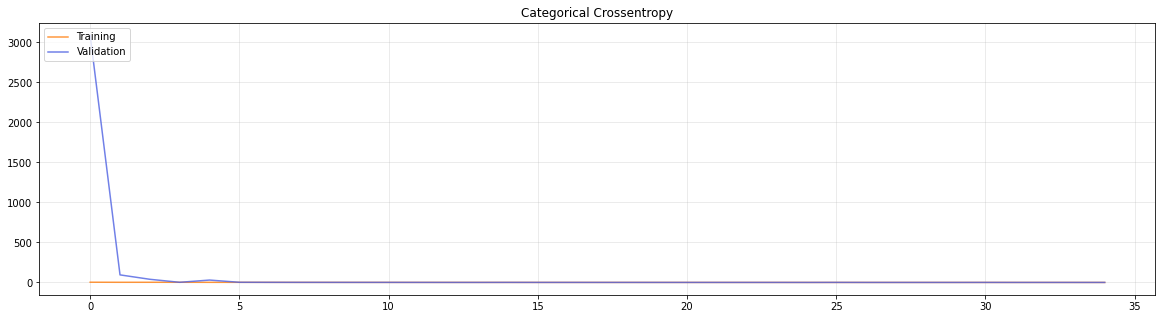

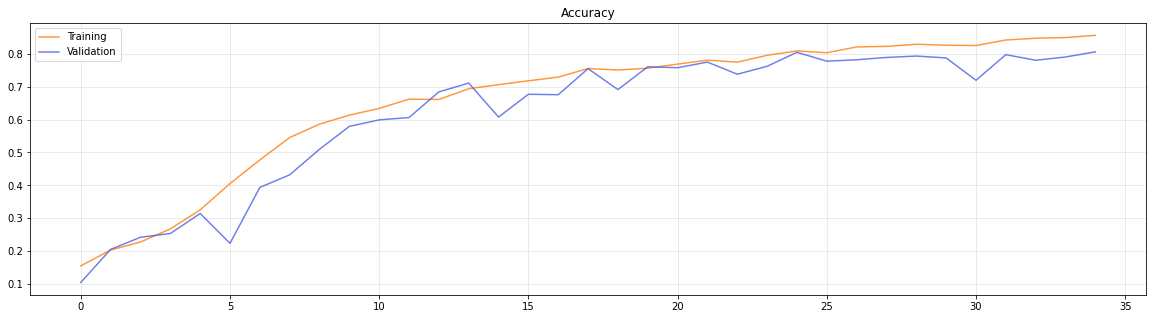

In [14]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(resnet_tl_history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(resnet_tl_history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(resnet_tl_history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(resnet_tl_history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# Training on Original and Augmented Data

In [9]:
## Train on original and augmented data
from keras.preprocessing.image import ImageDataGenerator

valid_data_gen = ImageDataGenerator(rescale=1/255., validation_split=0.2)

# Create an instance of ImageDataGenerator with Data Augmentation
comb_train_data_gen = ImageDataGenerator(validation_split=0.2,
                                        rescale=1/255.) # rescale value is multiplied to the image

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
comb_train_gen = comb_train_data_gen.flow_from_directory(directory='/gdrive/My Drive/AN2DL/training_data_combined/training_data_combined',
                                                       target_size=(256,256),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=64,
                                                       subset='training',
                                                       shuffle=True,
                                                       seed=seed)

comb_valid_gen = valid_data_gen.flow_from_directory('/gdrive/My Drive/AN2DL/training_data_combined/training_data_combined',
                                              target_size=(256,256),
                                              batch_size=64,
                                              color_mode='rgb',
                                              class_mode='categorical',
                                              classes=None,
                                              subset='validation',
                                              shuffle=True,
                                              seed=seed)

Found 5671 images belonging to 8 classes.
Found 1413 images belonging to 8 classes.


In [28]:
from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight(
           class_weight='balanced',
            classes=np.unique(comb_train_gen.classes), 
            y=comb_train_gen.classes)
class_weights_dict = dict(zip(np.unique(comb_train_gen.classes), class_weights))
class_weights_dict

{0: 2.3787751677852347,
 1: 0.8320129107981221,
 2: 0.8602851941747572,
 3: 0.8665953545232273,
 4: 0.8339705882352941,
 5: 1.9912219101123596,
 6: 0.8242732558139535,
 7: 0.8719249692496925}

In [31]:
## InceptionV3
iv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
inputs = tfk.Input(shape=input_shape)
x = iv3(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.5, seed=seed)(x)  
output_layer = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed),
    kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)


tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='tl_model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.SGD(learning_rate=0.0001), metrics=['accuracy'])


tl_model.summary()

Model: "tl_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 Flattening (Flatten)        (None, 73728)             0         
                                                                 
 dropout_8 (Dropout)         (None, 73728)             0         
                                                                 
 dense_8 (Dense)             (None, 8)                 589832    
                                                                 
Total params: 22,392,616
Trainable params: 22,358,184
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
# Create folders and callbacks and fit
iv3_tl_callbacks = create_folders_and_callbacks(model_name='CNN_IV3_BS64_SGD_CW_ALLDATA')

# Train the model
iv3_tl_history = tl_model.fit(
    x = comb_train_gen,
    epochs = epochs,
    validation_data = comb_valid_gen,
    class_weight = class_weights_dict,
    callbacks = iv3_tl_callbacks,
).history

Epoch 1/200
89/89 [==============================] - 70s 728ms/step - loss: 2.5477 - accuracy: 0.1435 - val_loss: 2.1667 - val_accuracy: 0.1805
Epoch 2/200
89/89 [==============================] - 63s 711ms/step - loss: 2.3149 - accuracy: 0.1867 - val_loss: 2.0347 - val_accuracy: 0.2222
Epoch 3/200
89/89 [==============================] - 63s 708ms/step - loss: 2.1692 - accuracy: 0.2116 - val_loss: 1.9208 - val_accuracy: 0.2838
Epoch 4/200
89/89 [==============================] - 63s 709ms/step - loss: 2.0726 - accuracy: 0.2435 - val_loss: 1.8385 - val_accuracy: 0.3255
Epoch 5/200
89/89 [==============================] - 63s 712ms/step - loss: 1.9720 - accuracy: 0.2760 - val_loss: 1.7536 - val_accuracy: 0.3687
Epoch 6/200
31/89 [=========>....................] - ETA: 34s - loss: 1.9126 - accuracy: 0.2894

In [ ]:
# Save best epoch model
tl_model.save("data_augmentation_experiments/CNN_IV3_BS64_SGD_CW_ALLDATA")

# Confusion Matrix on validation data

In [10]:
best_model = tfk.models.load_model("data_augmentation_experiments/CNN_IV3_BS64_SGD_CW_FT")
best_model.summary()

Model: "tl_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 Flattening (Flatten)        (None, 73728)             0         
                                                                 
 dropout_3 (Dropout)         (None, 73728)             0         
                                                                 
 dense_3 (Dense)             (None, 8)                 589832    
                                                                 
Total params: 22,392,616
Trainable params: 13,401,736
Non-trainable params: 8,990,880
_________________________________________________________________


In [38]:
### Setting shuffle=False for validation generator in order to obtain confusion matrix

from keras.preprocessing.image import ImageDataGenerator

valid_data_gen = ImageDataGenerator(rescale=1/255., validation_split=0.2)

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=90,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        shear_range=0.2,
                                        validation_split=0.2,
                                        rescale=1/255.) # rescale value is multiplied to the image

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory='/gdrive/My Drive/AN2DL/training_data_final',
                                                       target_size=(256,256),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=64,
                                                       subset='training',
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory('/gdrive/My Drive/AN2DL/training_data_final',
                                              target_size=(256,256),
                                              batch_size=64,
                                              color_mode='rgb',
                                              class_mode='categorical',
                                              classes=None,
                                              subset='validation',
                                              shuffle=False,
                                              seed=seed)

Found 2836 images belonging to 8 classes.
Found 706 images belonging to 8 classes.


In [39]:
batch_size=64

Y_pred = best_model.predict_generator(valid_gen, valid_gen.samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=-1)

print('Confusion Matrix')
print(confusion_matrix(valid_gen.classes, y_pred))

print('Classification Report')
target_names = ['Species1', 'Species2', 'Species3', 'Species4', 'Species5', 'Species6', 'Species7', 'Species8']
print(classification_report(valid_gen.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Confusion Matrix
[[ 28   2   2   1   0   2   0   2]
 [  0  99   1   1   0   1   1   3]
 [  1   0  97   0   5   0   0   0]
 [  0   1   2  94   5   0   0   0]
 [  1   1   2   4  97   1   0   0]
 [  2   0   0   0   0  41   0   1]
 [  0   2   0   0   0   0 103   2]
 [  5   2   1   0   0   1   1  91]]
Classification Report
              precision    recall  f1-score   support

    Species1       0.76      0.76      0.76        37
    Species2       0.93      0.93      0.93       106
    Species3       0.92      0.94      0.93       103
    Species4       0.94      0.92      0.93       102
    Species5       0.91      0.92      0.91       106
    Species6       0.89      0.93      0.91        44
    Species7       0.98      0.96      0.97       107
    Species8       0.92      0.90      0.91       101

    accuracy                           0.92       706
   macro avg       0.91      0.91      0.91       706
weighted avg       0.92      0.92      0.92       706



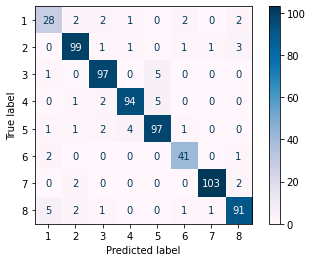

Accuracy: 0.9207
Precision: 0.9055
Recall: 0.9081
F1 Score: 0.9067


In [69]:
cm = confusion_matrix(valid_gen.classes, y_pred)
label_names=['1', '2', '3', '4', '5', '6', '7', '8']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

disp.plot(cmap=plt.cm.PuBu)
plt.show()
accuracy = accuracy_score(valid_gen.classes, y_pred)
precision = precision_score(valid_gen.classes, y_pred, average='macro')
recall = recall_score(valid_gen.classes, y_pred, average='macro')
f1 = f1_score(valid_gen.classes, y_pred, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1 Score:',f1.round(4))
